<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap10/transformers-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers fine tuning on IMDB for sentiment

**for this you either need a GPU in your machine or you need to run this on Colab**

* https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
* https://huggingface.co/docs/transformers/training#train-a-tensorflow-model-with-keras
* https://huggingface.co/docs/datasets/
* https://github.com/huggingface/datasets
* https://huggingface.co/datasets/imdb

## Installation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [ ]:
if IN_COLAB:
    # https://huggingface.co/transformers/installation.html
    !pip install -q transformers
    # https://huggingface.co/docs/datasets/installation.html
    !pip install -q datasets

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [3]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [4]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Tue Apr 26 08:13:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get and prepare data

In [8]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-455ebf651ee860b7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-175072174c1dd9cf.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [13]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-a2554c97a831f728.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b00d2fa2bdfea8ed.arrow


In [14]:
idx = 0
small_train_dataset['text'][idx]

'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'

In [15]:
# 0: neg, 1: pos
small_train_dataset['label'][idx]

1

## Get pretrained model and fine tune

In [16]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 1 to 3 minutes per epoch on decent GPU (e.g. V100 1min, T4 3min)
# don't train for too long, model will overfit
EPOCHS = 5
# reduce batch size when you encoder OOM error
# note, model has more than 100M parameters
# batch size 8 doable on 16GB
BATCH_SIZE = 8
# don't forget, we are fine tuning, increasing the LR might even increase overfitting
LR = 5e-5

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

In [19]:
%%time

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=EPOCHS)

Epoch 1/5
125/125 [==============================] - 189s 1s/step - loss: 0.6955 - sparse_categorical_accuracy: 0.5350 - val_loss: 0.5229 - val_sparse_categorical_accuracy: 0.7690
Epoch 2/5
125/125 [==============================] - 162s 1s/step - loss: 0.6424 - sparse_categorical_accuracy: 0.6210 - val_loss: 0.6984 - val_sparse_categorical_accuracy: 0.5120
Epoch 3/5
125/125 [==============================] - 162s 1s/step - loss: 0.7094 - sparse_categorical_accuracy: 0.4930 - val_loss: 0.6950 - val_sparse_categorical_accuracy: 0.4880
Epoch 4/5
125/125 [==============================] - 162s 1s/step - loss: 0.7023 - sparse_categorical_accuracy: 0.5070 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.5120
Epoch 5/5
125/125 [==============================] - 162s 1s/step - loss: 0.6964 - sparse_categorical_accuracy: 0.5280 - val_loss: 0.6972 - val_sparse_categorical_accuracy: 0.4880
CPU times: user 7min 15s, sys: 1min 15s, total: 8min 30s
Wall time: 15min 56s


## Evaluate results

In [20]:
model.evaluate(tf_train_dataset)

125/125 [==============================] - 44s 331ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.4880


[0.697141170501709, 0.4880000054836273]

In [21]:
# training data set too small to not overfit on it
model.evaluate(tf_validation_dataset)

125/125 [==============================] - 41s 331ms/step - loss: 0.6972 - sparse_categorical_accuracy: 0.4880


[0.6971579194068909, 0.4880000054836273]

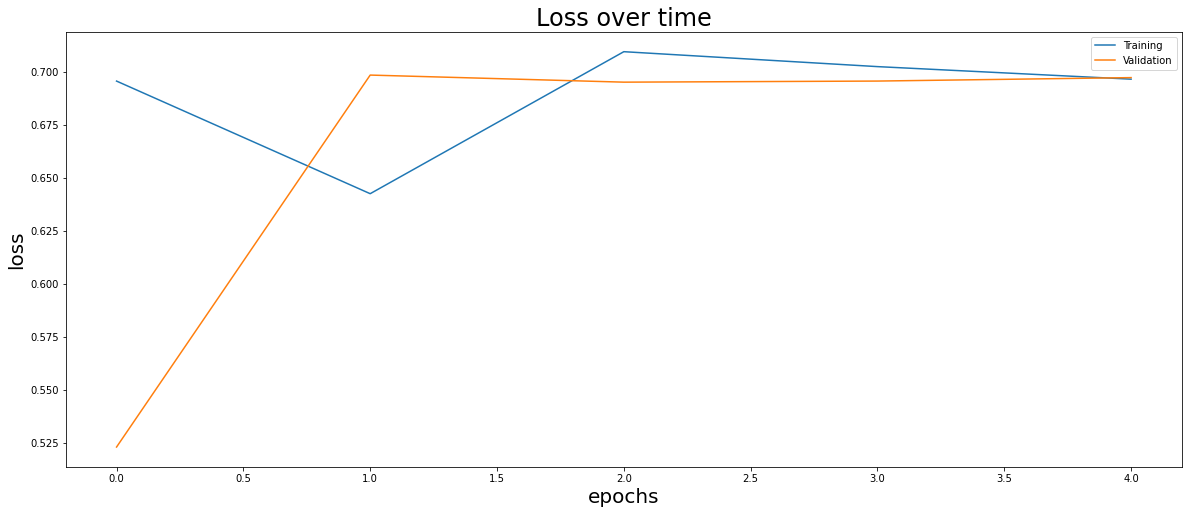

In [22]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

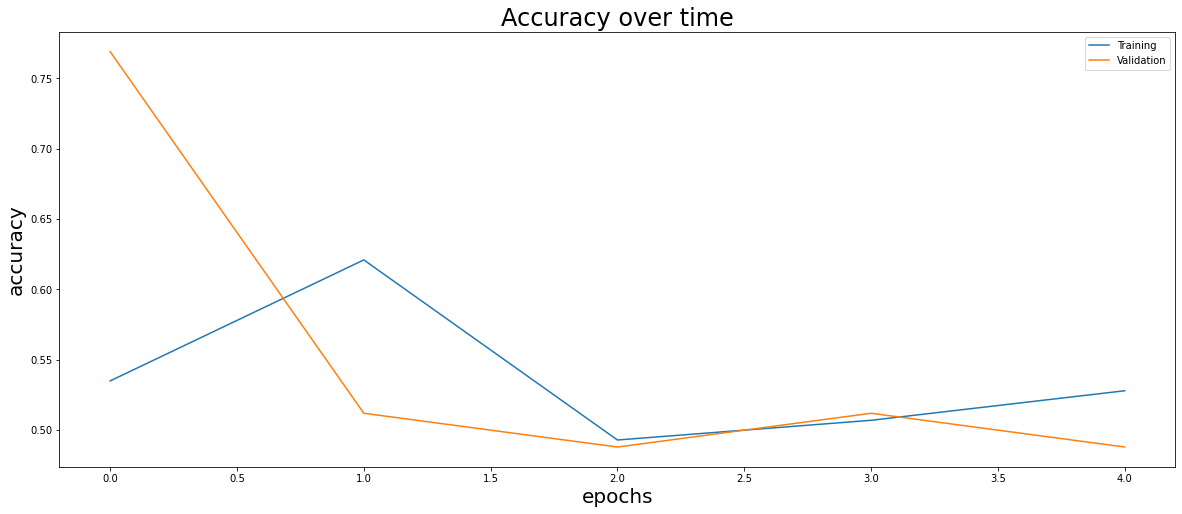

In [23]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Try out our fine tuned model

Quoting from https://huggingface.co/datasets/imdb
* neg: 0
* pos: 1

https://huggingface.co/transformers/task_summary.html#sequence-classification

In [24]:
movie1 = 'Two small cats seek and find adventures. Nice if you like cute movies.'

In [25]:
movie2 = 'Zombies attack a kindergarden. Splatter!'

In [26]:
movies = [movie1, movie2]

In [27]:
inputs = tokenizer(movies, padding="max_length", truncation=True, return_tensors="tf")

In [28]:
# this seems to be a good movie
tf.nn.softmax(model(inputs)[0])[0].numpy()

array([0.4650326 , 0.53496736], dtype=float32)

In [29]:
# this one not so much
tf.nn.softmax(model(inputs)[0])[1].numpy()

array([0.46867326, 0.5313268 ], dtype=float32)